<a href="https://colab.research.google.com/github/Leo-Lifeblood/Projects/blob/main/Off_Policy_Policy_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install gymnasium

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Categorical

In [39]:
torch.set_default_device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
import random

In [41]:
from collections import deque

In [42]:
import gymnasium as gym

In [43]:
class MLP(nn.Module):
    def __init__(self, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.LazyLinear(128)
        self.relu = nn.ReLU()
        self.fc2 = nn.LazyLinear(output_dim)
        self.value_head = nn.LazyLinear(1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [44]:
!apt-get update
!apt-get install -y build-essential python3-dev swig
!pip install gymnasium[box2d]

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,615 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,477 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,700 kB]
Get:14 

In [45]:
from IPython.display import clear_output

In [46]:
class off_policy_pg:
  def __init__(self, model, accumulation_steps=4, clipnorm=0.001, replay_buffer_length=32, entropy_coefficient=0.01):
    self.model = model
    self.optimizer = optim.Adam(model.parameters(), lr=0.001)

    self.states = []
    self.actions = []
    self.rewards = []
    self.log_probs = []

    self.state_buffer = deque(maxlen=replay_buffer_length)
    self.action_buffer = deque(maxlen=replay_buffer_length)
    self.return_buffer = deque(maxlen=replay_buffer_length)
    self.log_prob_buffer = deque(maxlen=replay_buffer_length)

    self.accumulation_steps = accumulation_steps
    self.accumulation_counter = 0

    self.clipnorm = clipnorm

    self.entropy_coefficient = entropy_coefficient



  def add_experience(self, state, action, reward, log_prob):
    self.states.append(state)
    self.actions.append(action)
    self.rewards.append(reward)
    self.log_probs.append(log_prob)

  def discount_rewards(self, rewards, gamma=0.99):
    discounted_rewards = []
    cumulative_reward = 0
    for reward in reversed(rewards):
      cumulative_reward = reward + gamma * cumulative_reward
      discounted_rewards.append(cumulative_reward)
    return list(reversed(discounted_rewards))


  def integrate_episode(self):
    self.state_buffer.append(torch.tensor(self.states))
    self.action_buffer.append(torch.tensor(self.actions))
    returns = self.discount_rewards(self.rewards)
    self.return_buffer.append(torch.tensor(returns))
    self.log_prob_buffer.append(torch.tensor(self.log_probs))

    self.states = []
    self.actions = []
    self.rewards = []
    self.log_probs = []

  def predict_action(self, state):
    with torch.no_grad():
      state = torch.tensor(state)
      self.model.eval()
      logits = self.model(state)
      self.model.train()
      dist = Categorical(logits=logits)
      action = dist.sample()
      log_prob = dist.log_prob(action)
    return action.item(), log_prob.item()

  def train_step(self):
    memory = list(zip(self.state_buffer, self.action_buffer, self.return_buffer, self.log_prob_buffer))

    #print(memory)

    random.shuffle(memory)

    returns_for_statistics = torch.concatenate(list(self.return_buffer))
    returns_for_statistics = returns_for_statistics.detach().flatten()
    returns_std = returns_for_statistics.std().detach()
    returns_mean = returns_for_statistics.mean().detach()



    for state, action, return_val, log_prob in memory:
      model_logits = self.model(state)
      dist = Categorical(logits=model_logits)
      log_prob_new = dist.log_prob(action)
      prior_cumsum = torch.cumsum(log_prob, dim=-1)         # faster way
      re_prior_cumsum = log_prob - prior_cumsum + prior_cumsum[-1:None]
      posterior_cumsum = torch.cumsum(log_prob_new, dim=-1)
      re_prior_cumsum = log_prob_new - posterior_cumsum + posterior_cumsum[-1:None]
      ratio = torch.exp(posterior_cumsum - prior_cumsum).detach()

      #ratio = torch.clamp(ratio, max=2)
      #plt.plot(ratio.detach().numpy())
      #plt.show()

      #return_val = (return_val - return_val.mean()) / (return_val.std() + 1e-8)

      return_val = (return_val - returns_mean) / (returns_std + 1e-8)


      #print(ratio.round(decimals=3))

      loss = -torch.mean(log_prob_new * ratio * return_val) -torch.mean(self.entropy_coefficient * dist.entropy())

      """
      weight = 1/(1+torch.abs(ratio-1))
      #plt.plot(weight.detach().numpy())
      #plt.show()
      loss = -torch.mean(log_prob_new * weight * return_val) -torch.mean(self.entropy_coefficient * dist.entropy())
      """

      if self.accumulation_counter == 0:
        self.optimizer.zero_grad()

      loss.backward()
      self.accumulation_counter += 1
      if self.accumulation_counter >= self.accumulation_steps:
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clipnorm)
        self.optimizer.step()
        self.accumulation_counter = 0


    pass






In [48]:
#env = gym.make('CartPole-v1')
env = gym.make("LunarLander-v3")
env = gym.wrappers.NormalizeObservation(env)

In [49]:
agent = off_policy_pg(MLP(env.action_space.n), accumulation_steps=4, replay_buffer_length=32, entropy_coefficient=0.0)#2)
#try with single behaviour policy ie make a behavior net dont update it and occasionally copy over updated weights

In [50]:
rewards = []

In [51]:
model = agent.model.state_dict()

In [52]:
agent.model.load_state_dict(model)

<All keys matched successfully>

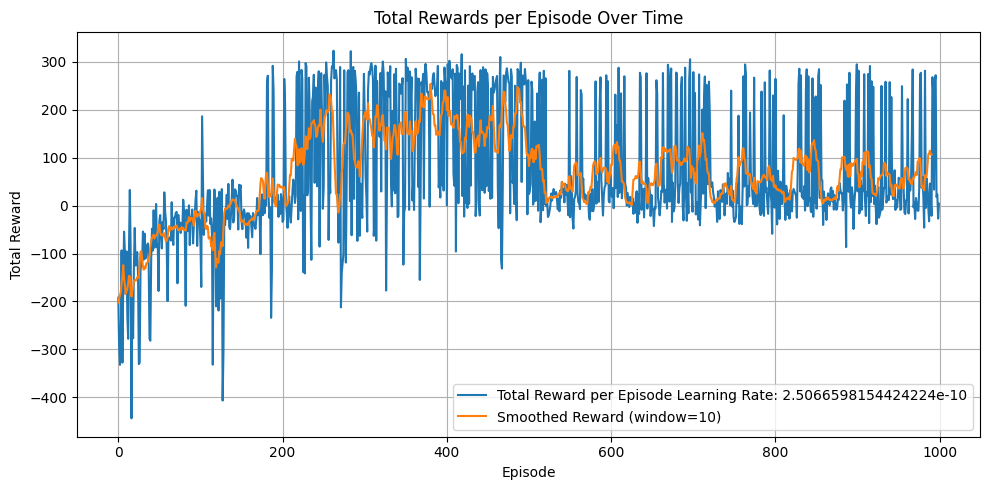

In [54]:
for episode_number in range(500):
  state, info = env.reset()
  done = False
  total_reward = 0
  while not done:
    action, log_prob = agent.predict_action(state)
    next_state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated
    agent.add_experience(state, action, reward, log_prob)
    state = next_state

  rewards.append(total_reward)
  #print(f"Episode Number: {episode_number+1} Total reward: {total_reward}")
  plt.figure(figsize=(10, 5))
  plt.plot(rewards, label=f'Total Reward per Episode Learning Rate: {agent.optimizer.param_groups[0]["lr"]}')
  window_size = 10
  smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
  plt.plot(smoothed_rewards, label=f'Smoothed Reward (window={window_size})')
  plt.xlabel('Episode')
  plt.ylabel('Total Reward')
  plt.title('Total Rewards per Episode Over Time')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  clear_output(wait=True)
  agent.integrate_episode()
  agent.train_step()
  #agent.optimizer.param_groups[0]['lr'] = agent.optimizer.param_groups[0]['lr'] * 0.97

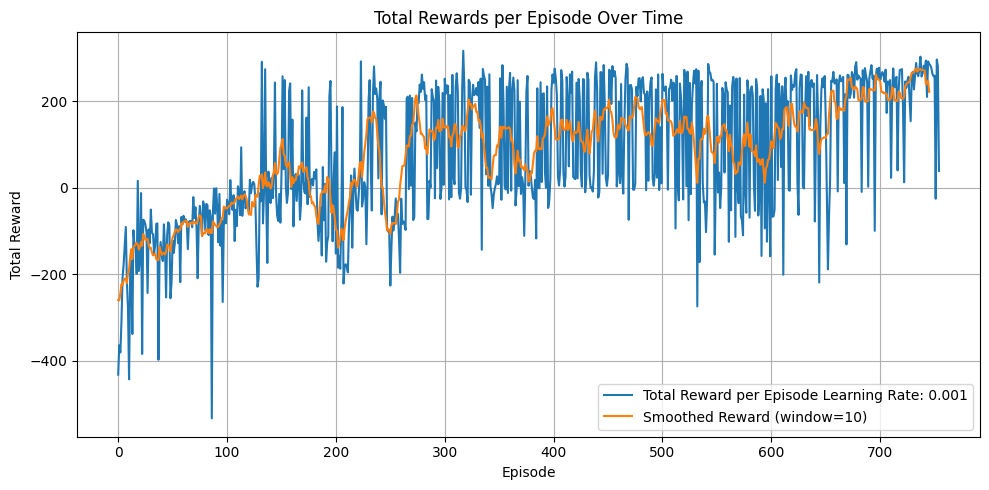

In [504]:
  plt.figure(figsize=(10, 5))
  plt.plot(rewards, label=f'Total Reward per Episode Learning Rate: {agent.optimizer.param_groups[0]["lr"]}')
  window_size = 10
  smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
  plt.plot(smoothed_rewards, label=f'Smoothed Reward (window={window_size})')
  plt.xlabel('Episode')
  plt.ylabel('Total Reward')
  plt.title('Total Rewards per Episode Over Time')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  clear_output(wait=True)
  agent.integrate_episode()
  agent.train_step()

In [9]:
agent = off_policy_pg(MLP(env.action_space.n), accumulation_steps=4, replay_buffer_length=128)

NameError: name 'off_policy_pg' is not defined

In [ ]:
rewards = []

In [ ]:
for episode_number in range(500):
  state, info = env.reset()
  done = False
  total_reward = 0
  while not done:
    action, log_prob = agent.predict_action(state)
    next_state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated
    agent.add_experience(state, action, reward, log_prob)
    state = next_state

  rewards.append(total_reward)
  #print(f"Episode Number: {episode_number+1} Total reward: {total_reward}")
  plt.figure(figsize=(10, 5))
  plt.plot(rewards, label='Total Reward per Episode')
  window_size = 10
  smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
  plt.plot(smoothed_rewards, label=f'Smoothed Reward (window={window_size})')
  plt.xlabel('Episode')
  plt.ylabel('Total Reward')
  plt.title('Total Rewards per Episode Over Time')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  clear_output(wait=True)
  agent.integrate_episode()
  agent.train_step()

In [55]:
class off_policy_pg:
  def __init__(self, model, accumulation_steps=4, clipnorm=0.001, replay_buffer_length=32, entropy_coefficient=0.01, clip_range=0.2,clip_decay=1):
    self.model = model
    self.optimizer = optim.Adam(model.parameters(), lr=0.001)

    self.states = []
    self.actions = []
    self.rewards = []
    self.log_probs = []

    self.state_buffer = deque(maxlen=replay_buffer_length)
    self.action_buffer = deque(maxlen=replay_buffer_length)
    self.return_buffer = deque(maxlen=replay_buffer_length)
    self.log_prob_buffer = deque(maxlen=replay_buffer_length)

    self.accumulation_steps = accumulation_steps
    self.accumulation_counter = 0

    self.clipnorm = clipnorm

    self.entropy_coefficient = entropy_coefficient
    self.clip_range = clip_range
    self.clip_decay = clip_decay



  def add_experience(self, state, action, reward, log_prob):
    self.states.append(state)
    self.actions.append(action)
    self.rewards.append(reward)
    self.log_probs.append(log_prob)

  def discount_rewards(self, rewards, gamma=0.99):
    discounted_rewards = []
    cumulative_reward = 0
    for reward in reversed(rewards):
      cumulative_reward = reward + gamma * cumulative_reward
      discounted_rewards.append(cumulative_reward)
    return list(reversed(discounted_rewards))


  def integrate_episode(self):
    self.state_buffer.append(torch.tensor(self.states))
    self.action_buffer.append(torch.tensor(self.actions))
    returns = self.discount_rewards(self.rewards)
    self.return_buffer.append(torch.tensor(returns))
    self.log_prob_buffer.append(torch.tensor(self.log_probs))

    self.states = []
    self.actions = []
    self.rewards = []
    self.log_probs = []

  def predict_action(self, state):
    with torch.no_grad():
      state = torch.tensor(state)
      self.model.eval()
      logits = self.model(state)
      self.model.train()
      dist = Categorical(logits=logits)
      action = dist.sample()
      log_prob = dist.log_prob(action)
    return action.item(), log_prob.item()

  def train_step(self):
    memory = list(zip(self.state_buffer, self.action_buffer, self.return_buffer, self.log_prob_buffer))

    #print(memory)

    random.shuffle(memory)

    returns_for_statistics = torch.concatenate(list(self.return_buffer))
    returns_for_statistics = returns_for_statistics.detach().flatten()
    returns_std = returns_for_statistics.std().detach()
    returns_mean = returns_for_statistics.mean().detach()



    for state, action, return_val, log_prob in memory:
      model_logits = self.model(state)
      dist = Categorical(logits=model_logits)
      log_prob_new = dist.log_prob(action)
      prior_cumsum = torch.cumsum(log_prob, dim=-1)         # faster way
      re_prior_cumsum = log_prob - prior_cumsum + prior_cumsum[-1:None]
      posterior_cumsum = torch.cumsum(log_prob_new, dim=-1)
      re_prior_cumsum = log_prob_new - posterior_cumsum + posterior_cumsum[-1:None]
      ratio = torch.exp(posterior_cumsum - prior_cumsum).detach()

      #ratio = torch.clamp(ratio, max=2)
      #plt.plot(ratio.detach().numpy())
      #plt.show()

      #return_val = (return_val - return_val.mean()) / (return_val.std() + 1e-8)

      return_val = (return_val - returns_mean) / (returns_std + 1e-8)


      #print(ratio.round(decimals=3))

      #loss = -torch.mean(log_prob_new * ratio * return_val) -torch.mean(self.entropy_coefficient * dist.entropy())

      surr1 = torch.exp(log_prob_new - log_prob.detach()) * ratio * return_val
      surr2 = torch.clamp(torch.exp(log_prob_new - log_prob.detach()), 1-self.clip_range, 1+self.clip_range)  * ratio * return_val
      loss = -torch.mean(torch.min(surr1, surr2)) -torch.mean(self.entropy_coefficient * dist.entropy())

      """
      weight = 1/(1+torch.abs(ratio-1))
      #plt.plot(weight.detach().numpy())
      #plt.show()
      loss = -torch.mean(log_prob_new * weight * return_val) -torch.mean(self.entropy_coefficient * dist.entropy())
      """

      if self.accumulation_counter == 0:
        self.optimizer.zero_grad()

      loss.backward()
      self.accumulation_counter += 1
      if self.accumulation_counter >= self.accumulation_steps:
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clipnorm)
        self.optimizer.step()
        self.accumulation_counter = 0
        self.clip_range *= self.clip_decay


    pass






In [56]:
#env = gym.make('CartPole-v1')
env = gym.make("LunarLander-v3")
env = gym.wrappers.NormalizeObservation(env)

In [60]:
agent = off_policy_pg(MLP(env.action_space.n), accumulation_steps=4, replay_buffer_length=32, entropy_coefficient=0.02, clip_range=1, clip_decay=0.9997)#2)
#try with single behaviour policy ie make a behavior net dont update it and occasionally copy over updated weights

In [61]:
rewards = []

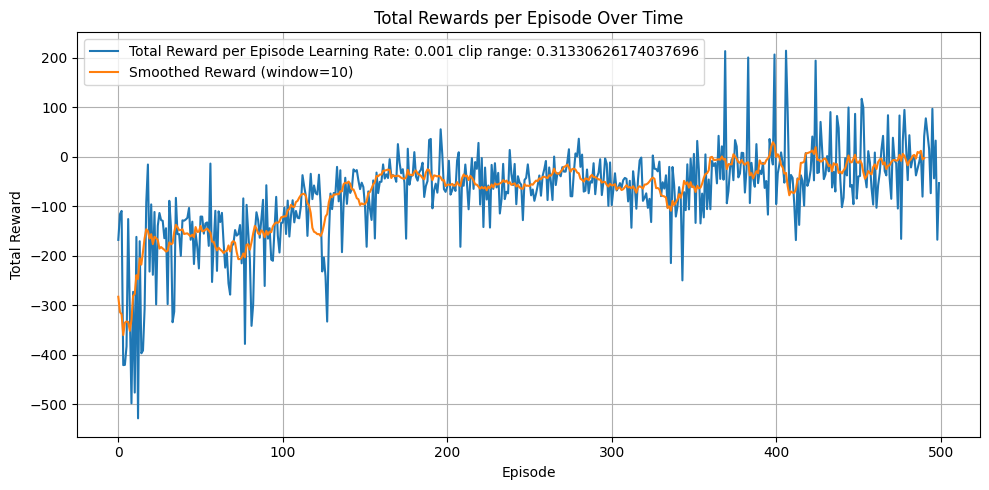

In [62]:
for episode_number in range(500):
  state, info = env.reset()
  done = False
  total_reward = 0
  while not done:
    action, log_prob = agent.predict_action(state)
    next_state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated
    agent.add_experience(state, action, reward, log_prob)
    state = next_state

  rewards.append(total_reward)
  #print(f"Episode Number: {episode_number+1} Total reward: {total_reward}")
  plt.figure(figsize=(10, 5))
  plt.plot(rewards, label=f'Total Reward per Episode Learning Rate: {agent.optimizer.param_groups[0]["lr"]} clip range: {agent.clip_range}')
  window_size = 10
  smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
  plt.plot(smoothed_rewards, label=f'Smoothed Reward (window={window_size})')
  plt.xlabel('Episode')
  plt.ylabel('Total Reward')
  plt.title('Total Rewards per Episode Over Time')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  clear_output(wait=True)
  agent.integrate_episode()
  agent.train_step()
  #agent.optimizer.param_groups[0]['lr'] = agent.optimizer.param_groups[0]['lr'] * 0.97